In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')
from time import (time)

In [ ]:
# Import modules
import numpy as np
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.sql.types import ArrayType, StringType, BooleanType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from google.cloud import storage
from google.cloud import bigquery
from pprint import pprint

# Custom Imports
from Utils import (loadConfig, loadPathsConfig)
from DataPreprocessing.DatasetManager import (DatasetManager)
from DataPreprocessing.DaskDataFrame import (DaskDataframe)
from DataPreprocessing.DatasetAnalyser import (DatasetAnalyser)

---
# [Tests] Dask DataFrame pipeline

In [67]:
# Create a instance of a dask DataFrame
ds = DaskDataframe(config=config, pathsConfig=pathsConfig)

In [68]:
# Load the chosen tables of the dataset into dataframes
ds.loadAllData()

In [69]:
# Join/Merge the chosen tables' dataframes into a main dask DataFrame
ds.join()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,SEQ_NUM,ICD9_CODE,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,string,string,string,string,string,string,string,string,string,string,string,string,string,string,float64,float64,float64,string,float64,string,string,string,float64,float64,string,string,float64,string,string,string,string,string,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [70]:
# Inspect the shape of the DataFrame
ds.shape(dataframe=ds.df)

(714344, 35)

In [71]:
# Get the columns to remove
columnsToRemove = ds.getUselessColumns()

In [72]:
# Drop the fecthed columns
ds.dropColumns(columns=columnsToRemove)

In [73]:
# Evaluate the missing data on the DataFrame
ds.checkMissingValues(ds.df)

                  Column  MissingValuesCount  MissingValuesPercentage(%)
4               LANGUAGE              219546                       30.73
6         MARITAL_STATUS               71920                       10.07
15                   LOS                8488                        1.19
14         LAST_CAREUNIT                8423                        1.18
13        FIRST_CAREUNIT                8423                        1.18
12              DBSOURCE                8423                        1.18
5               RELIGION                3286                        0.46
8              DIAGNOSIS                  95                        0.01
10               SEQ_NUM                  47                        0.01
11             ICD9_CODE                  47                        0.01
0         ADMISSION_TYPE                   0                        0.00
9   HAS_CHARTEVENTS_DATA                   0                        0.00
1     ADMISSION_LOCATION                   0       

In [74]:
# Inspect the shape of the DataFrame
ds.shape(dataframe=ds.df)

(714344, 17)

In [75]:
# Drop all the rows with NaN values
ds.dropNanRows()

In [78]:
# Inspect the shape of the DataFrame
ds.shape(dataframe=ds.df)

(473743, 17)

In [77]:
# Evaluate the missing data on the DataFrame
ds.checkMissingValues(ds.df)

                  Column  MissingValuesCount  MissingValuesPercentage(%)
0         ADMISSION_TYPE                   0                         0.0
9   HAS_CHARTEVENTS_DATA                   0                         0.0
15                   LOS                   0                         0.0
14         LAST_CAREUNIT                   0                         0.0
13        FIRST_CAREUNIT                   0                         0.0
12              DBSOURCE                   0                         0.0
11             ICD9_CODE                   0                         0.0
10               SEQ_NUM                   0                         0.0
8              DIAGNOSIS                   0                         0.0
1     ADMISSION_LOCATION                   0                         0.0
7              ETHNICITY                   0                         0.0
6         MARITAL_STATUS                   0                         0.0
5               RELIGION                   0       

---

In [6]:
# Create a Apache Spark Session
spark = SparkSession.builder \
    .appName("Intensive Care Unit Data Analysis") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.memory.fraction", "0.9") \
    .config("spark.memory.storageFraction", "0.5") \
    .getOrCreate()

# check spark configs to only errors:

spark.sparkContext.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "500")
spark.conf.set("spark.sql.debug.maxToStringFields", "1000")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "C:\Users\Gongas\anaconda3\envs\LSDS\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "C:\Users\Gongas\anaconda3\envs\LSDS\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "C:\Users\Gongas\anaconda3\envs\LSDS\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [7]:
# Create a dataset manager
dsManager = DatasetManager(sparkSession=spark, config=config, pathsConfig=pathsConfig)

---
## Tests regarding spark dataframes manipulation

In [8]:
# [TESTS] Print the dataframes inside the dictionary
dsManager.dataframes
# type(dsManager.dataframes['ADMISSIONS'])

{'ADMISSIONS': None, 'DIAGNOSES_ICD': None, 'ICUSTAYS': None, 'PATIENTS': None}

In [9]:
# Testing the timit decorator
# result = dsManager.printConfig()
df = dsManager.loadDataFrame(filename='ADMISSIONS')

In [10]:
# %%timeit
admissions = dsManager.loadDataFrame(filename='ADMISSIONS')
print("\n", admissions.describe(), "\n")
admissions.limit(3).toPandas()


 DataFrame[summary: string, SUBJECT_ID: string, HADM_ID: string, ADMISSION_TYPE: string, ADMISSION_LOCATION: string, DISCHARGE_LOCATION: string, INSURANCE: string, LANGUAGE: string, RELIGION: string, MARITAL_STATUS: string, ETHNICITY: string, DIAGNOSIS: string, HOSPITAL_EXPIRE_FLAG: string, HAS_CHARTEVENTS_DATA: string] 



,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,22,165315,2196-04-09 11:26:00,2196-04-10 14:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 09:06:00,2196-04-09 12:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,23,152223,2153-09-03 06:15:00,2153-09-08 18:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,124321,2157-10-18 18:34:00,2157-10-25 13:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1


In [11]:
# %%timeit
# chartEvents = dsManager.loadDataFrame(filename='CHARTEVENTS')
# print("\n", chartEvents.describe(), "\n")
# chartEvents.limit(3).toPandas()

In [12]:
# %%timeit
diagnosis = dsManager.loadDataFrame(filename='DIAGNOSES_ICD')
print("\n", diagnosis.describe(), "\n")
diagnosis.limit(3).toPandas()


 DataFrame[summary: string, SUBJECT_ID: string, HADM_ID: string, SEQ_NUM: string, ICD9_CODE: string] 



,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,109,172335,1,40301
1,109,172335,2,486
2,109,172335,3,58281


In [13]:
# %%timeit
icuStays = dsManager.loadDataFrame(filename='ICUSTAYS')
print("\n", icuStays.describe(), "\n")
icuStays.limit(3).toPandas()


 DataFrame[summary: string, SUBJECT_ID: string, HADM_ID: string, ICUSTAY_ID: string, DBSOURCE: string, FIRST_CAREUNIT: string, LAST_CAREUNIT: string, FIRST_WARDID: string, LAST_WARDID: string, LOS: string] 



,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 14:05:20,2128-06-27 11:32:29,2.8939


In [14]:
# %%timeit
patients = dsManager.loadDataFrame(filename='PATIENTS')
print("\n", patients.describe(), "\n")
patients.limit(3).toPandas()


 DataFrame[summary: string, SUBJECT_ID: string, GENDER: string, EXPIRE_FLAG: string] 



,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,249,F,2075-03-13,NaT,NaT,NaT,0
1,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1
2,251,M,2090-03-15,NaT,NaT,NaT,0


---

In [15]:
# Load all the dataframes
dsManager.loadAllDataFrames()

In [16]:
# Join the loaded dataframes
join_df = dsManager.joinDataFrames()

In [17]:
# Compute the shape of the dataframe with
nrows, ncols = dsManager.shape(dataframe=join_df)
print(f"The dataframe resultant from the join operations between the available dataframes contains {nrows} rows and {ncols} columns")

The dataframe resultant from the join operations between the available dataframes contains 714344 rows and 35 columns


In [18]:
# Evaluate the amount of missing data per column
dsManager.checkMissingValues(df=join_df)

+--------------+------------------+--------------------------+
|        Column|MissingValuesCount|MissingValuesPercentage(%)|
+--------------+------------------+--------------------------+
|     DEATHTIME|            616701|                     86.33|
|      DOD_HOSP|            480148|                     67.22|
|       DOD_SSN|            441659|                     61.83|
|           DOD|            382113|                     53.49|
|     EDREGTIME|            293643|                     41.11|
|     EDOUTTIME|            293643|                     41.11|
|      LANGUAGE|            219546|                     30.73|
|MARITAL_STATUS|             71920|                     10.07|
|       OUTTIME|              8488|                      1.19|
|           LOS|              8488|                      1.19|
|    ICUSTAY_ID|              8423|                      1.18|
|      DBSOURCE|              8423|                      1.18|
|FIRST_CAREUNIT|              8423|                    

In [19]:
# Evaluate the amount of unique values per column
dsManager.checkColumnsAmountUniqueValues(df=join_df) 

-RECORD 0---------------------
 SUBJECT_ID           | 46520 
 HADM_ID              | 58976 
 ADMITTIME            | 58651 
 DISCHTIME            | 58657 
 DEATHTIME            | 5834  
 ADMISSION_TYPE       | 4     
 ADMISSION_LOCATION   | 9     
 DISCHARGE_LOCATION   | 17    
 INSURANCE            | 5     
 LANGUAGE             | 75    
 RELIGION             | 20    
 MARITAL_STATUS       | 7     
 ETHNICITY            | 41    
 EDREGTIME            | 30874 
 EDOUTTIME            | 30864 
 DIAGNOSIS            | 15691 
 HOSPITAL_EXPIRE_FLAG | 2     
 HAS_CHARTEVENTS_DATA | 2     
 SEQ_NUM              | 39    
 ICD9_CODE            | 6984  
 ICUSTAY_ID           | 61532 
 DBSOURCE             | 3     
 FIRST_CAREUNIT       | 6     
 LAST_CAREUNIT        | 6     
 FIRST_WARDID         | 16    
 LAST_WARDID          | 17    
 INTIME               | 61531 
 OUTTIME              | 61518 
 LOS                  | 40175 
 GENDER               | 2     
 DOB                  | 32540 
 DOD    

In [20]:
# Checking the amount of missing data in a singular column
missingData = dsManager.getColumnMissingValues(df=join_df, column='LANGUAGE')
missingData.show()

+-------------------------+
|[LANGUAGE] Missing Values|
+-------------------------+
|                   219546|
+-------------------------+



In [21]:
# Checking the unique values on a certain column
uniqueValues = dsManager.getColumnUniqueValues(df=join_df, column='LANGUAGE')
uniqueValues.show(5)

+--------+-----------+
|LANGUAGE|Total Count|
+--------+-----------+
|    NULL|     219546|
|    * BE|         12|
|    * FU|         14|
|    ** T|          9|
|    **SH|         31|
+--------+-----------+
only showing top 5 rows



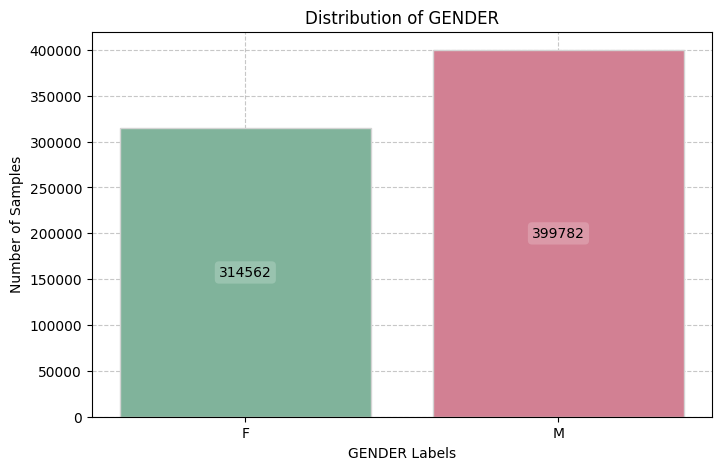

In [91]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='GENDER')

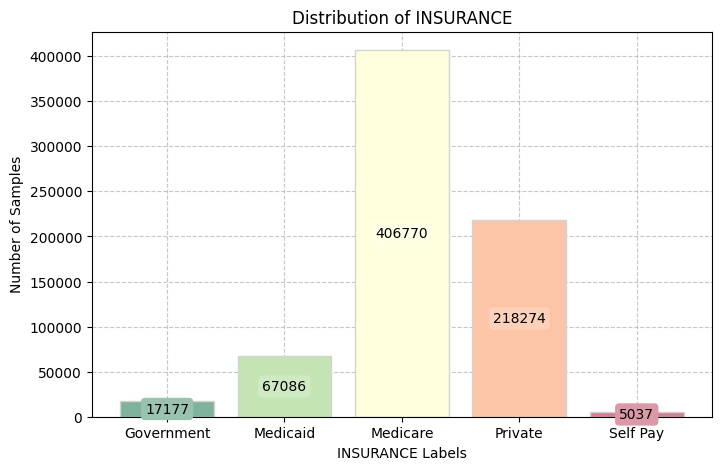

In [72]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='INSURANCE')

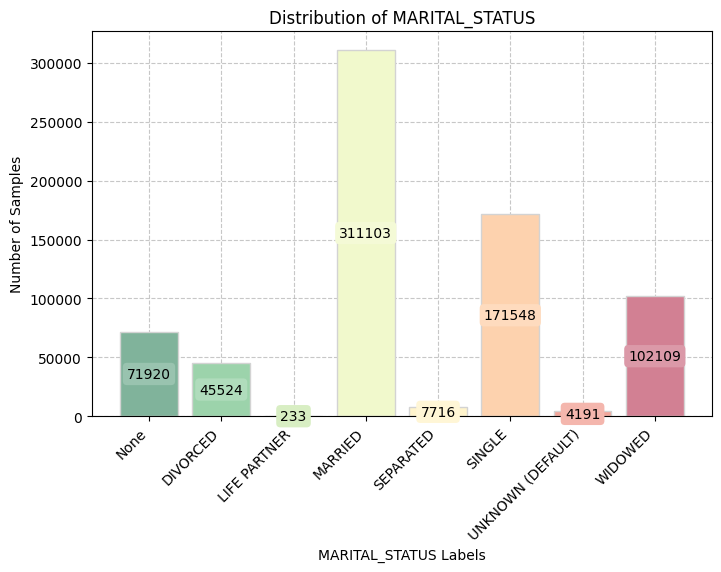

In [76]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='MARITAL_STATUS')

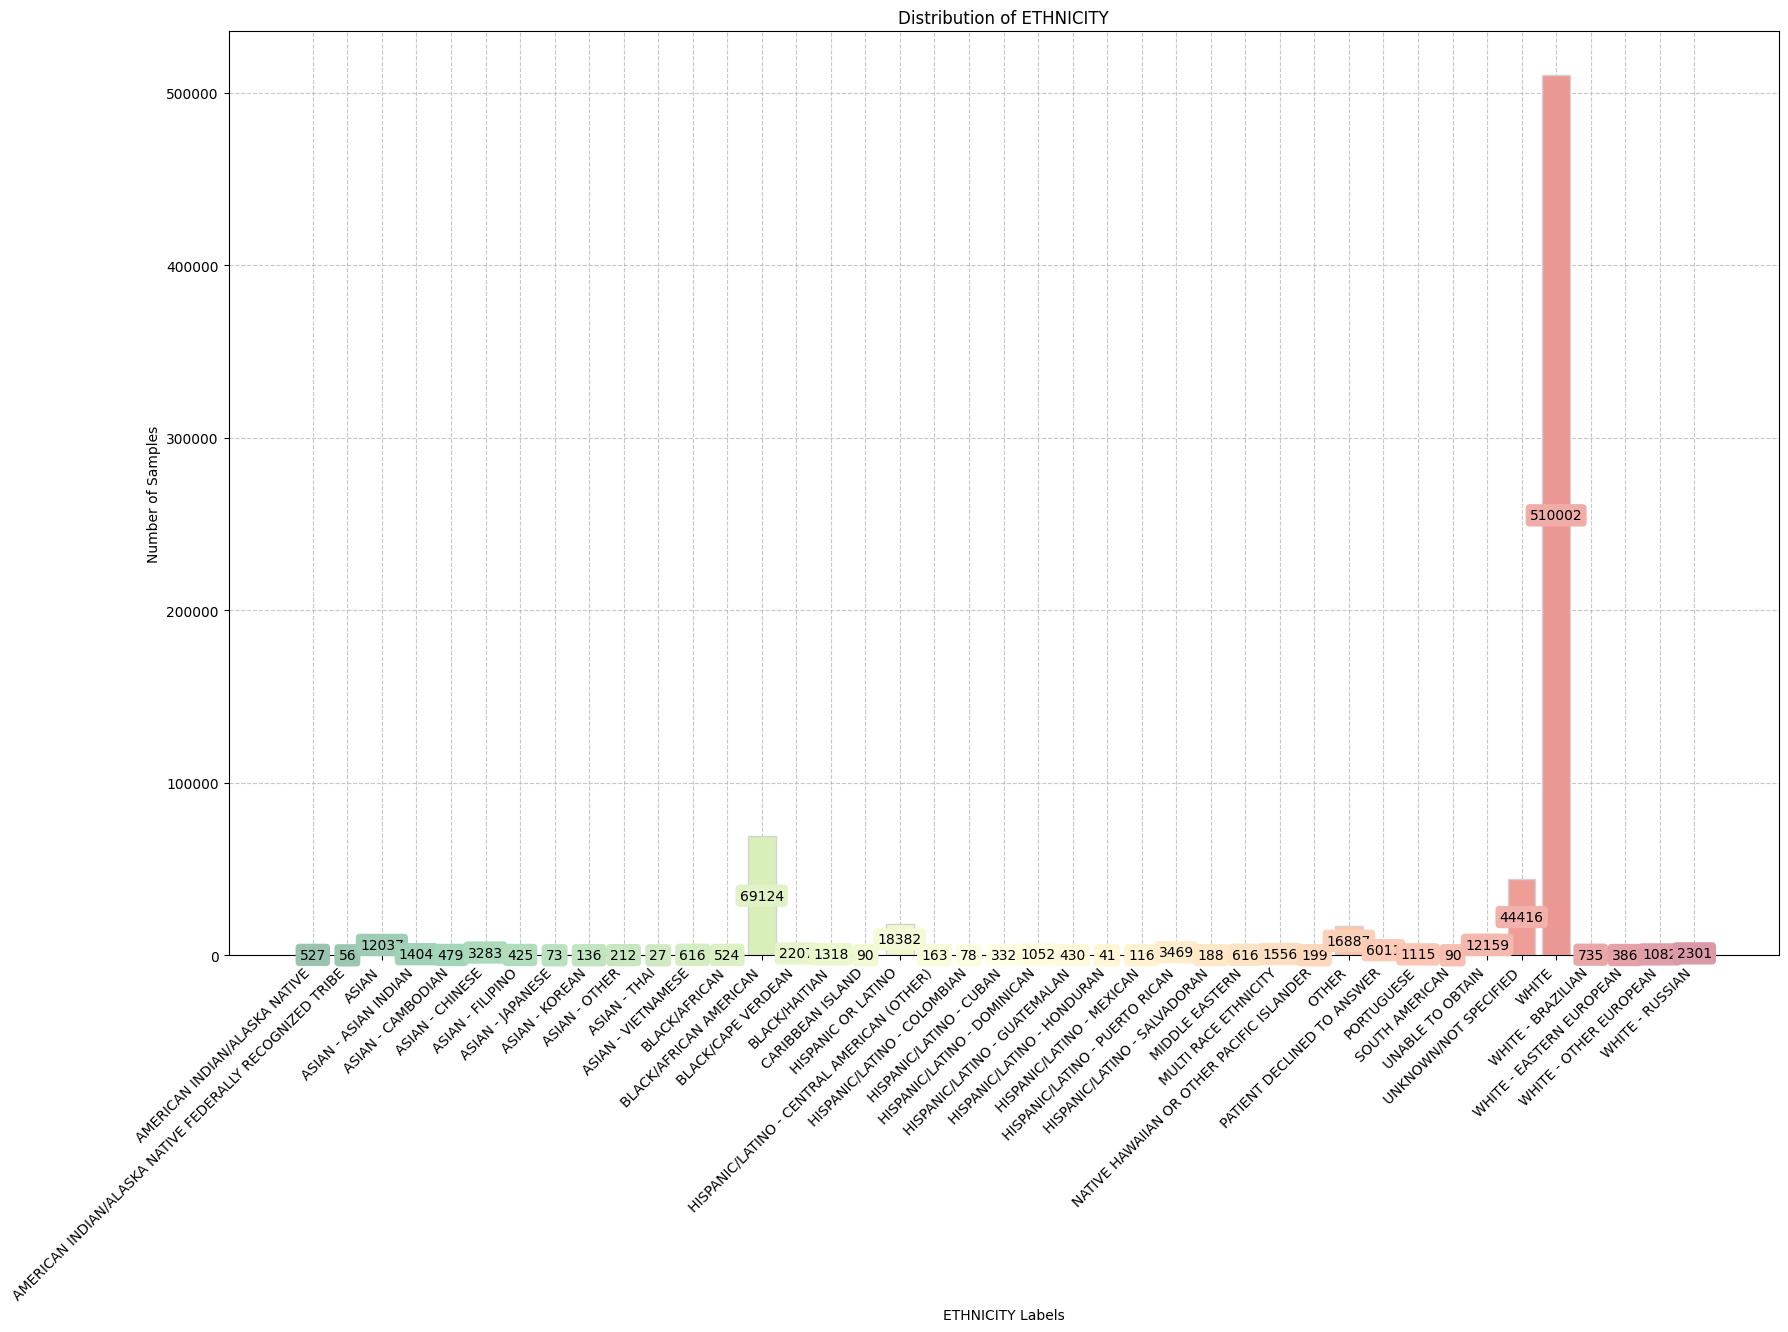

In [67]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='ETHNICITY')

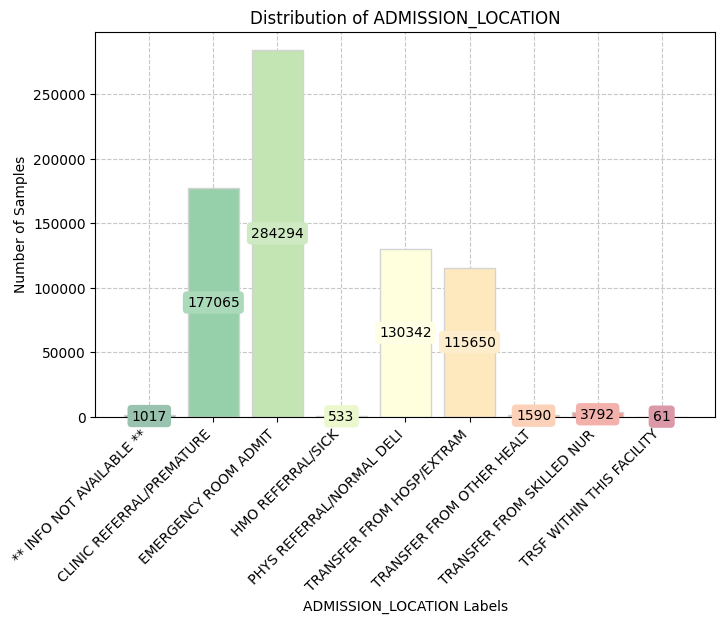

In [68]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='ADMISSION_LOCATION')

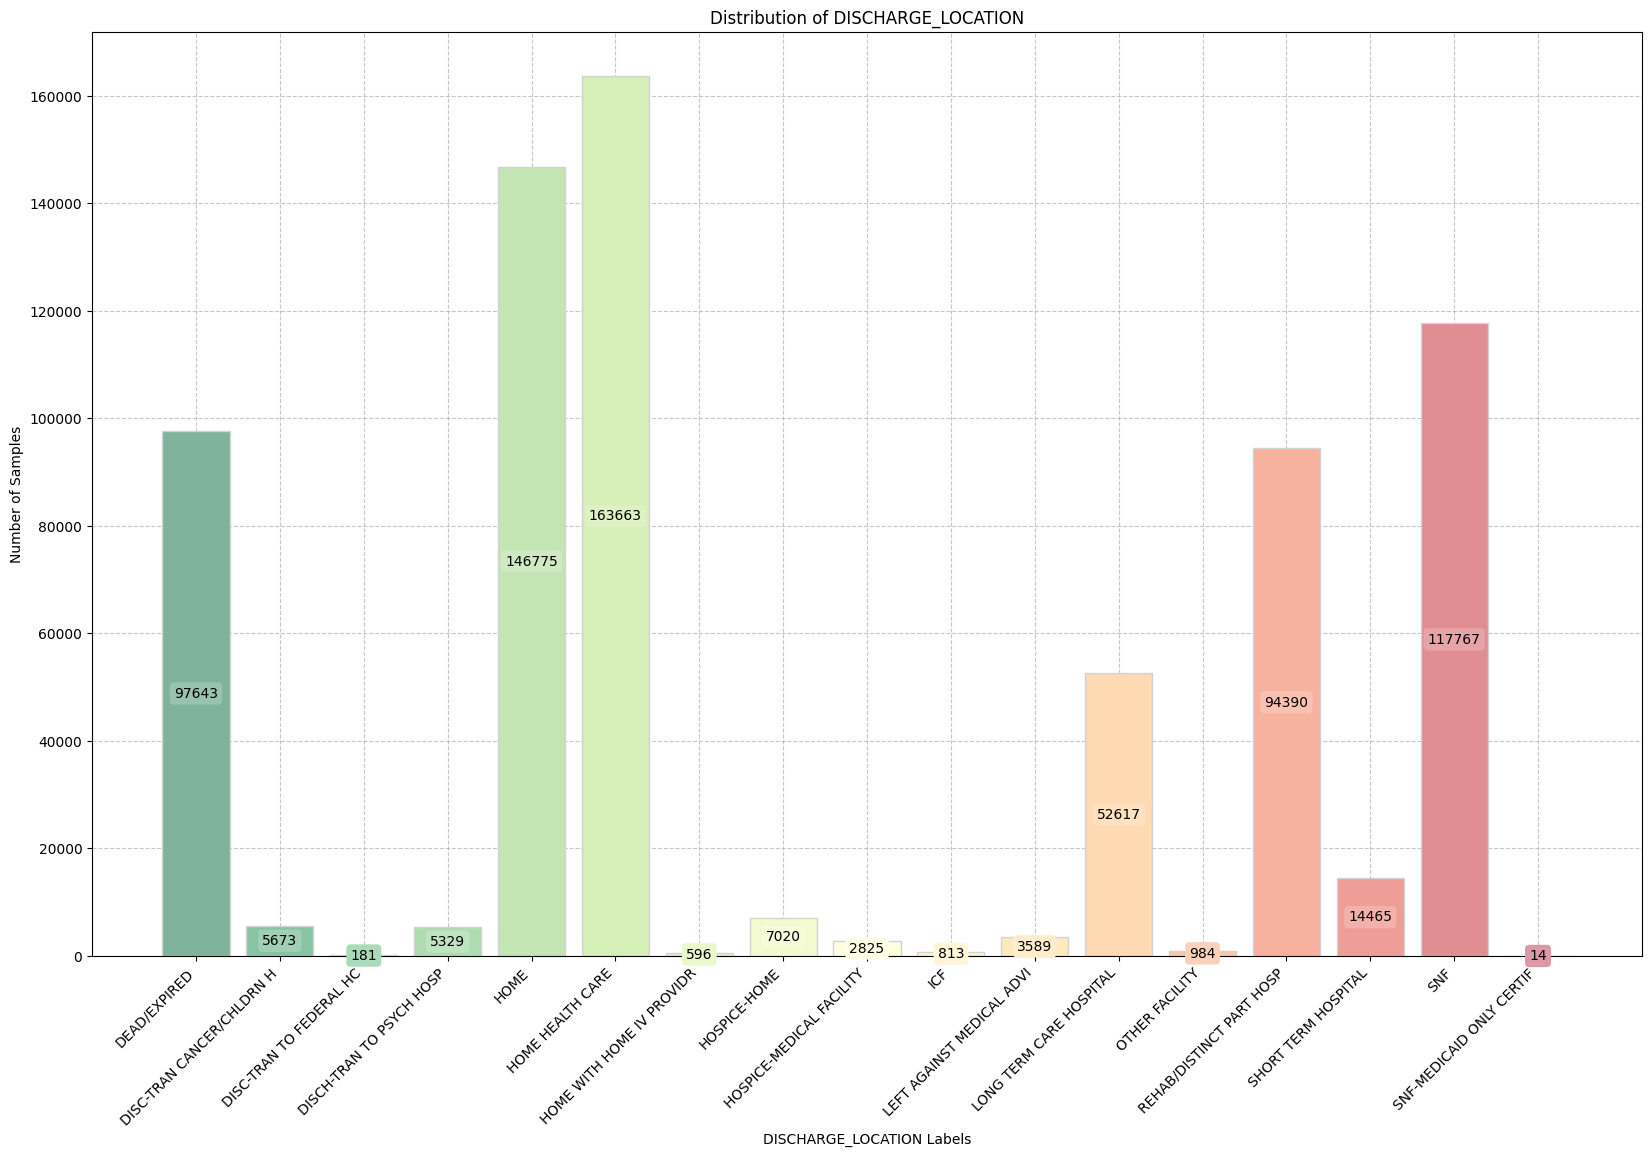

In [69]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='DISCHARGE_LOCATION')

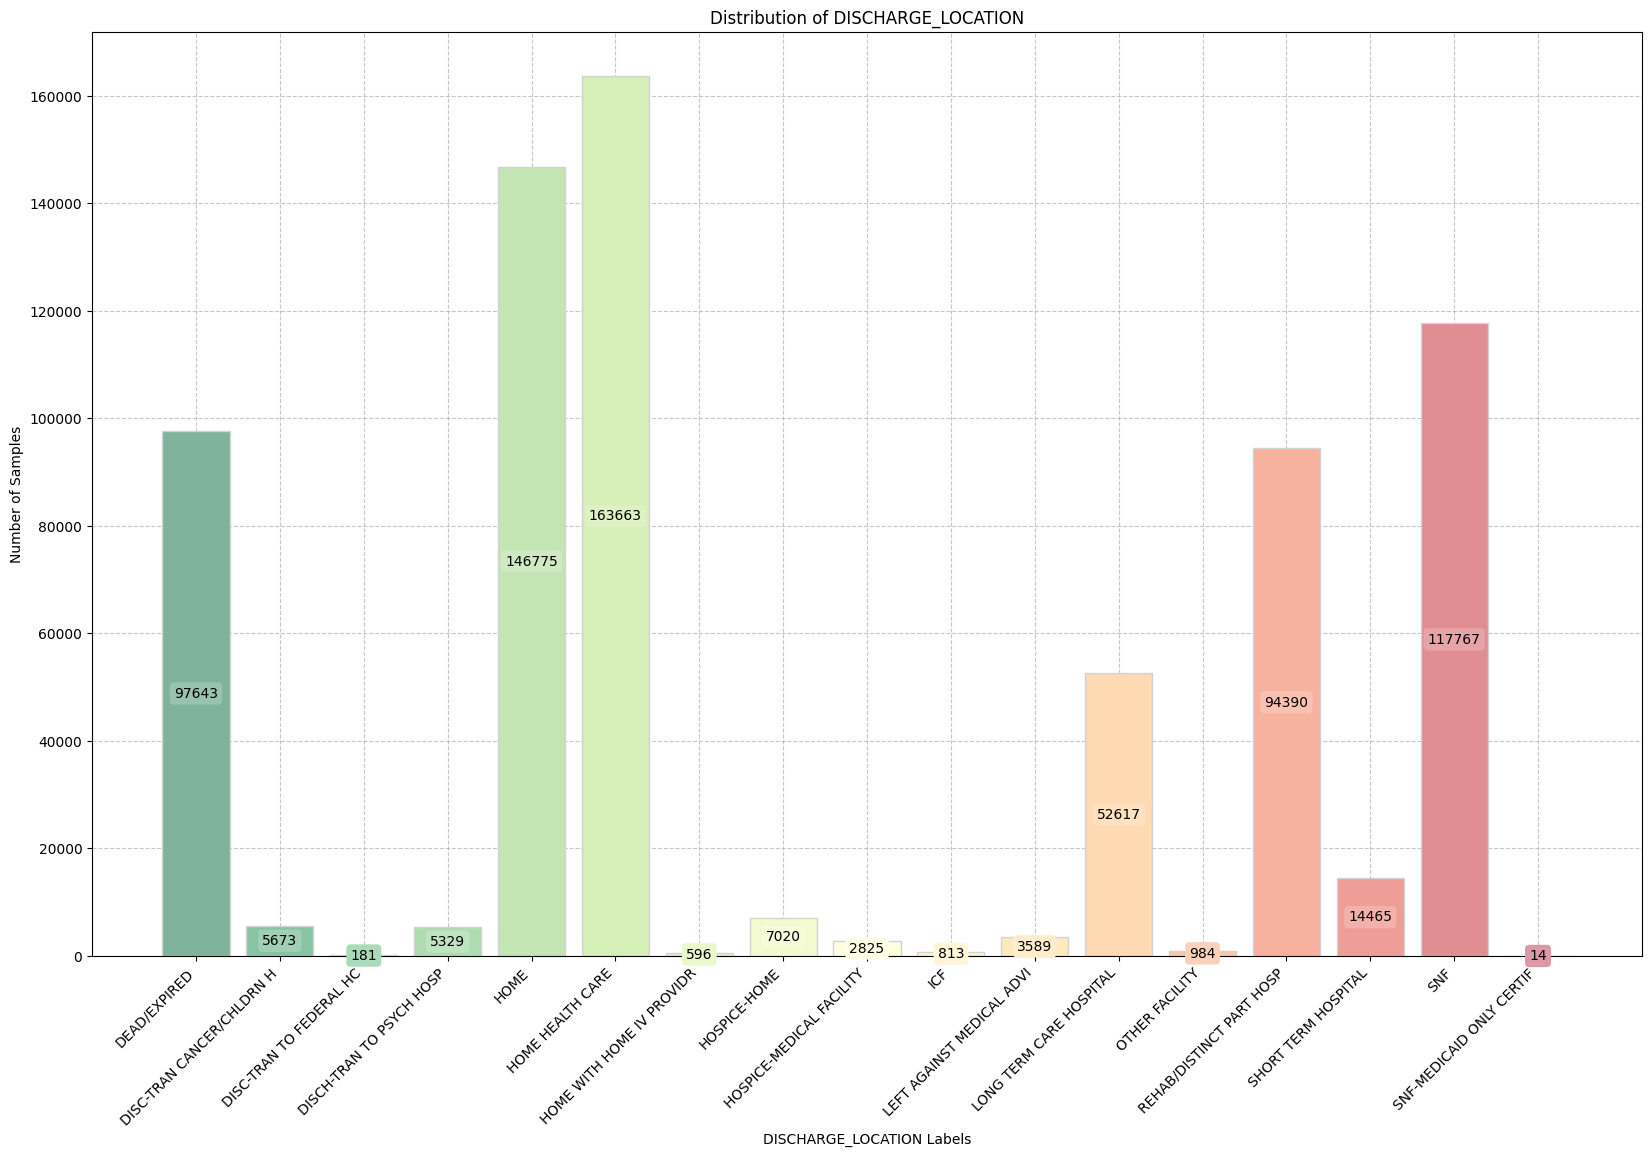

In [70]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='DISCHARGE_LOCATION')

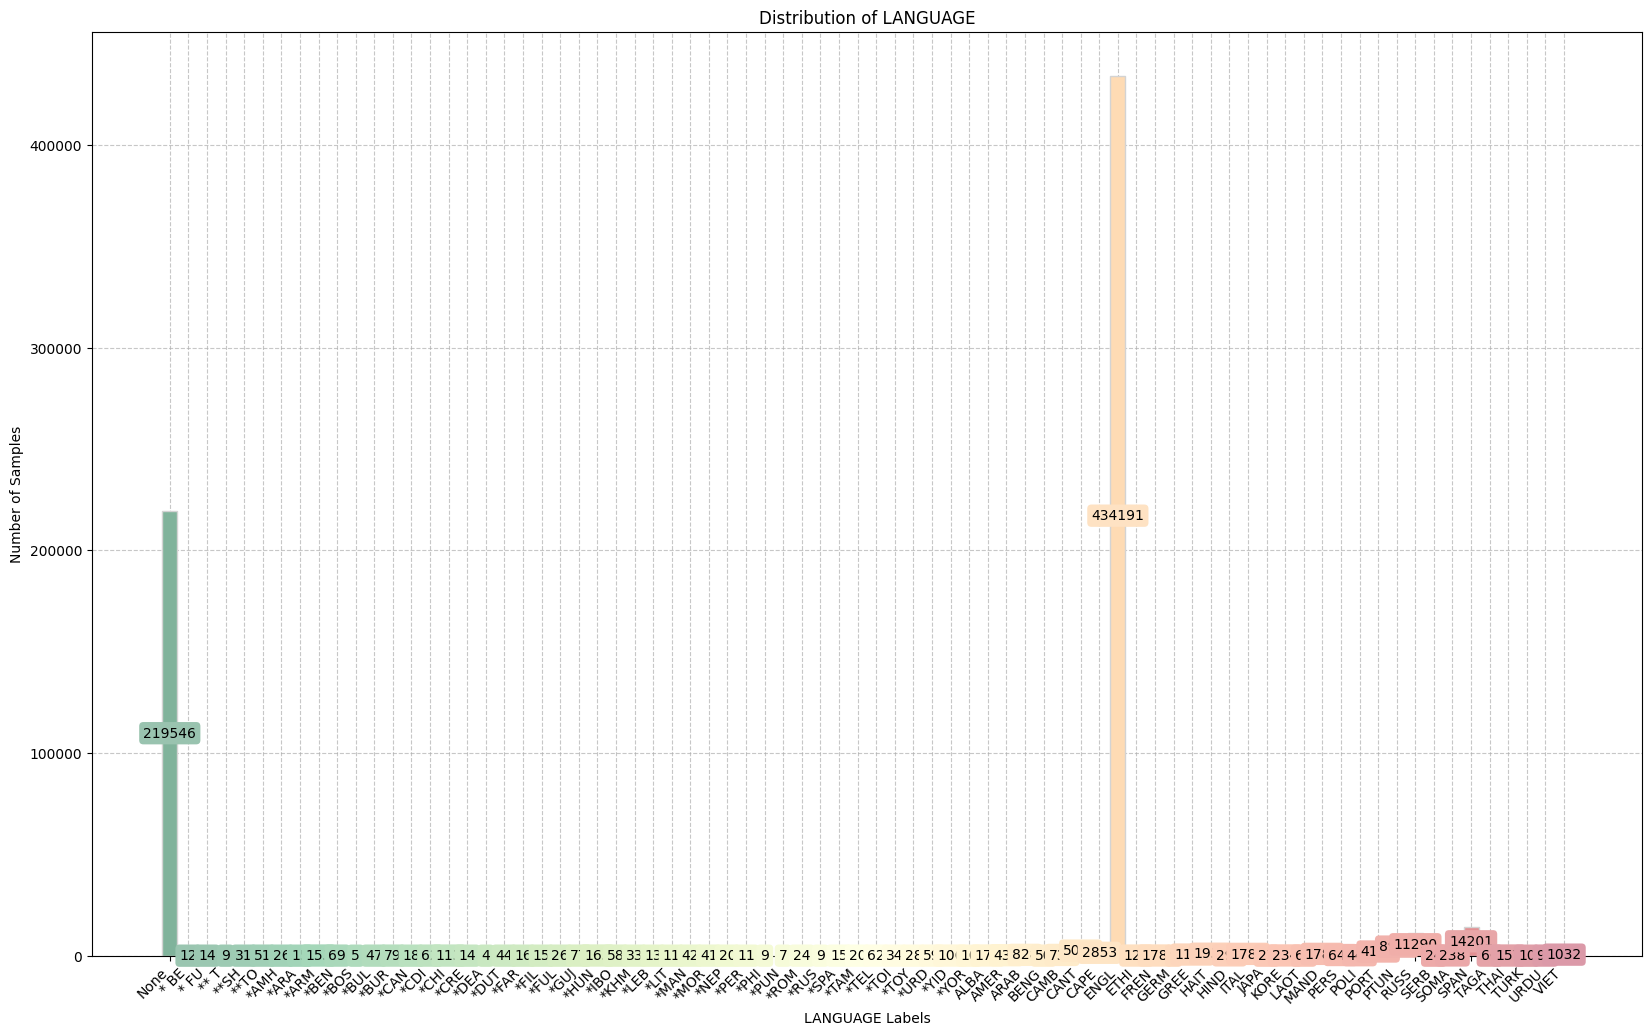

In [75]:
# Create a DatasetAnalyser and check some feature distributions
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature='LANGUAGE')

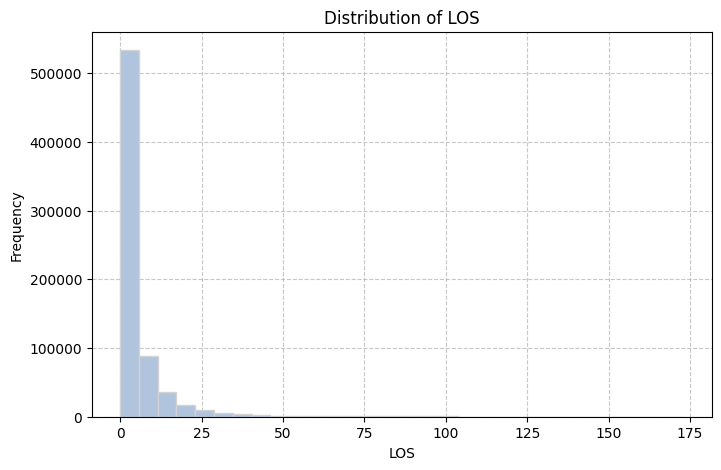

In [71]:
# Create a DatasetAnalyser and check the target feature distribution
da = DatasetAnalyser(df=join_df)
da.plotFeatureDistribution(feature=config['targetFeature'])

In [56]:
# Trying to sort unnecessary columns

# Fetching ID related columns
idColumns = [col for col in join_df.columns if 'ID' in col]
print(idColumns)

# Fetching time related columns
timeColumns = [col for col in join_df.columns if 'TIME' in col]
print(timeColumns)

# Fetching date related columns
datesColumns = [col for col in join_df.columns if 'DOB' in col or 'DOD' in col]
print(datesColumns)

# Fetching flag related columns
flagColumns = [col for col in join_df.columns if 'FLAG' in col]
print(flagColumns)

# Removing non important columns
cols = list(join_df.columns)
for elem in idColumns + timeColumns + datesColumns + flagColumns:
    cols.remove(elem)

cols

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'FIRST_WARDID', 'LAST_WARDID']
['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME', 'INTIME', 'OUTTIME']
['DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN']
['HOSPITAL_EXPIRE_FLAG', 'EXPIRE_FLAG']


['ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'DIAGNOSIS',
 'HAS_CHARTEVENTS_DATA',
 'SEQ_NUM',
 'ICD9_CODE',
 'DBSOURCE',
 'FIRST_CAREUNIT',
 'LAST_CAREUNIT',
 'LOS',
 'GENDER']

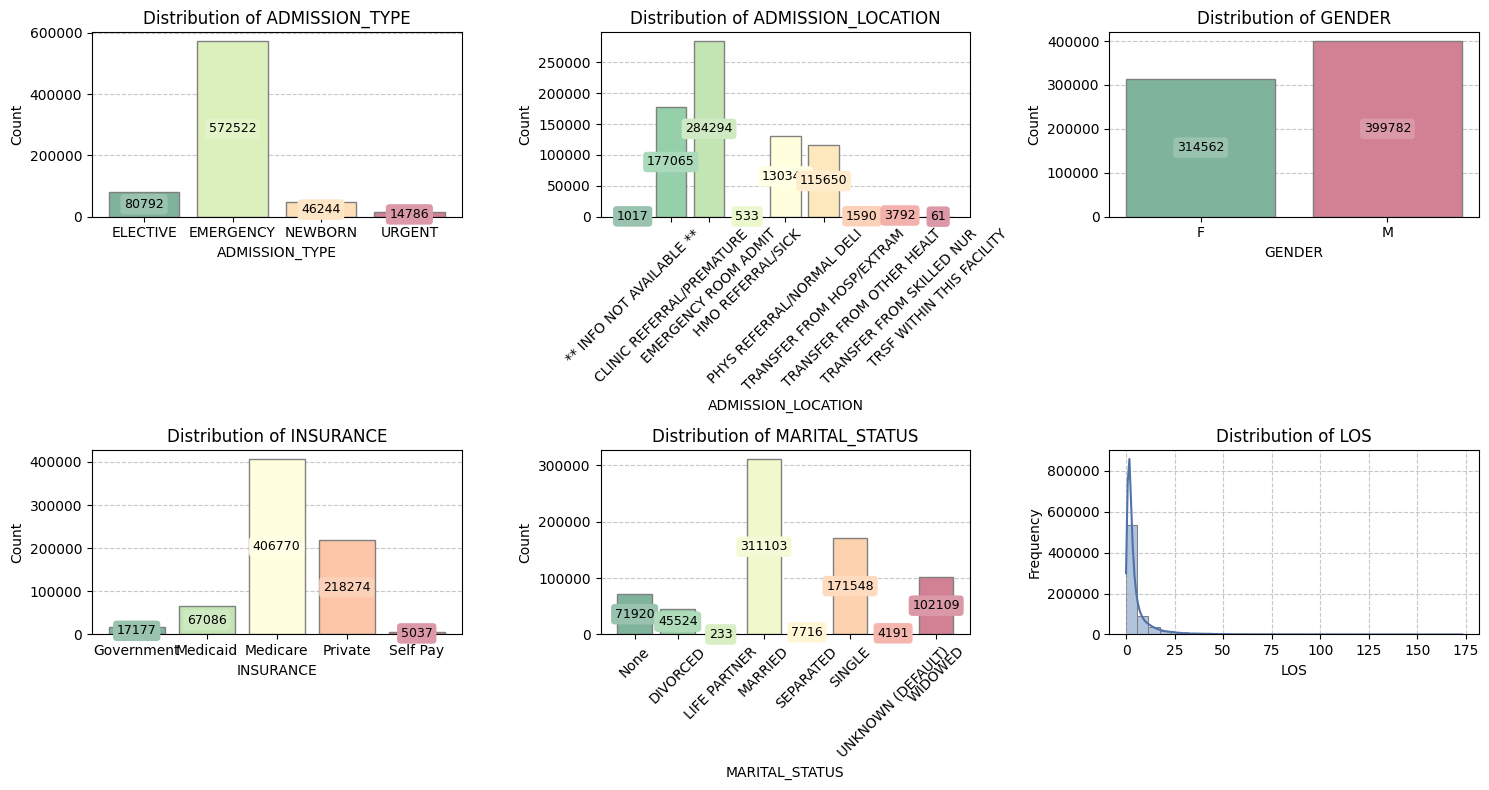

In [92]:
da.plotFeatureDistributions(features=['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'GENDER', 'INSURANCE', 'MARITAL_STATUS', 'LOS'])